# Integrating mC and RNA using Harmony

## Import

In [1]:
import pandas as pd
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

from harmonypy import run_harmony
from ALLCools.mcds import MCDS
from ALLCools.clustering import significant_pc_test, tsne, log_scale, balanced_pca, calculate_direct_confusion
from ALLCools.plot import *

## Parameter

In [2]:
cell_meta_path = '../step_by_step/100kb/L1.ClusteringResults.csv.gz'
mcds_path = '../dmg/gene_frac/*.mcds'
dmg_result_path = '../dmg/L1.OneVsRestDMG.hdf'

var_dim = 'gene'
mc_type = 'CHN'  # for neurons, CHN capture cell-type-specific gene body diversity better

# PCA
p_cutoff = 0.1

n_neighbors = 25
resolution = 1

## Load mC data

In [3]:
cell_meta = pd.read_csv(cell_meta_path, index_col=0)
mcds = MCDS.open(mcds_path)
mcds.add_cell_metadata(cell_meta)  # add cell meta into mcds

mcds

<xarray.MCDS>
Dimensions:                  (cell: 5127, gene: 35664, mc_type: 2)
Coordinates: (12/26)
  * mc_type                  (mc_type) object 'CGN' 'CHN'
  * cell                     (cell) object '3C_M_1015' '3C_M_0' ... '9H_M_3057'
  * gene                     (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUS...
    strand_type              <U4 'both'
    gene_chrom               (gene) object dask.array<chunksize=(35664,), meta=np.ndarray>
    gene_start               (gene) int64 dask.array<chunksize=(35664,), meta=np.ndarray>
    ...                       ...
    cell_tsne_1              (cell) float64 -23.56 -29.98 ... -8.787 49.84
    cell_umap_0              (cell) float64 2.516 -2.627 3.549 ... 16.21 9.587
    cell_umap_1              (cell) float64 13.24 16.95 10.3 ... 0.7527 -7.494
    cell_L1                  (cell) object 'c6' 'c1' 'c7' ... 'c4' 'c4' 'c14'
    cell_L1_proba            (cell) float64 0.4175 0.8896 ... 0.6577 0.9471
    cell_CellTypeAnno.1      (cell) object 'IT-L4' 'IT-L23' ... 'CA1' 'IG-CA2'
Data variables:
    gene_da_frac             (cell, gene, mc_type) float32 dask.array<chunksize=(1202, 35664, 2), meta=np.ndarray>

## mC data preprocess

In [4]:
dmg_result = pd.read_hdf(dmg_result_path)
use_genes = dmg_result.index.unique(
)  # we use all the cluster DMGs as input features
mc_adata = mcds.sel({
    var_dim: use_genes
}).get_adata(mc_type=mc_type, var_dim=var_dim, select_hvf=False)

# reverse the mC because mC fraction negatively correlated with RNA expression
mc_adata.X *= -1

# scale
sc.pp.scale(mc_adata)

mc_adata

AnnData object with n_obs × n_vars = 5127 × 4852
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'CellInputReadPairs', 'MappingRate', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'leiden', 'mCHFrac.1', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno.1'
    var: 'chrom', 'start', 'end', 'mean', 'std'

## Load RNA data

The RNA data is already preprocessed in a separate notebook

In [5]:
rna_adata = anndata.read_h5ad('RNA.norm.log1p.HVG.scale.h5ad')
rna_adata

AnnData object with n_obs × n_vars = 8517 × 1999
    obs: 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cell_type_designation_label', 'external_donor_name_color', 'external_donor_name_order', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_order', 'facs_population_plan_label', 'injection_materials_color'

## Merge datasets

In [6]:
use_genes = rna_adata.var_names.intersection(mc_adata.var_names)

adata = mc_adata[:, use_genes].concatenate(rna_adata[:, use_genes],
                                           index_unique=None)
adata.obs['batch'] = adata.obs['batch'].map({'0': 'mC', '1': 'RNA'})
adata

/home/hanliu/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


AnnData object with n_obs × n_vars = 13644 × 930
    obs: 'mCCCFrac', 'mCGFrac', 'mCHFrac', 'FinalmCReads', 'CellInputReadPairs', 'MappingRate', 'Plate', 'Col384', 'Row384', 'CellTypeAnno', 'leiden', 'mCHFrac.1', 'tsne_0', 'tsne_1', 'umap_0', 'umap_1', 'L1', 'L1_proba', 'CellTypeAnno.1', 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cel

## PCA

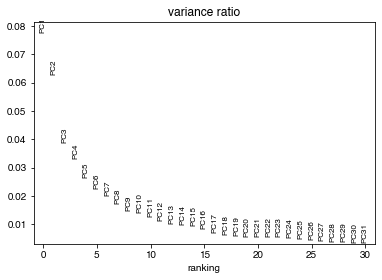

36 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (13644, 100) to (13644, 36)


In [7]:
sc.pp.pca(adata, n_comps=100)
sc.pl.pca_variance_ratio(adata)
n_components = significant_pc_test(adata, p_cutoff=p_cutoff)

## Run Harmony on the PCs

In [8]:
ho = run_harmony(adata.obsm['X_pca'],
                 meta_data=adata.obs,
                 vars_use='batch',
                 random_state=0)
adata.obsm['X_pca'] = ho.Z_corr.T

2021-03-12 23:20:46,209 - harmonypy - INFO - Iteration 1 of 10
2021-03-12 23:20:50,108 - harmonypy - INFO - Iteration 2 of 10
2021-03-12 23:20:54,071 - harmonypy - INFO - Iteration 3 of 10
2021-03-12 23:20:58,533 - harmonypy - INFO - Iteration 4 of 10
2021-03-12 23:21:02,511 - harmonypy - INFO - Iteration 5 of 10
2021-03-12 23:21:06,454 - harmonypy - INFO - Iteration 6 of 10
2021-03-12 23:21:10,150 - harmonypy - INFO - Iteration 7 of 10
2021-03-12 23:21:14,015 - harmonypy - INFO - Converged after 7 iterations


### Plot Integrated PCs

Red axis labels are used PCs


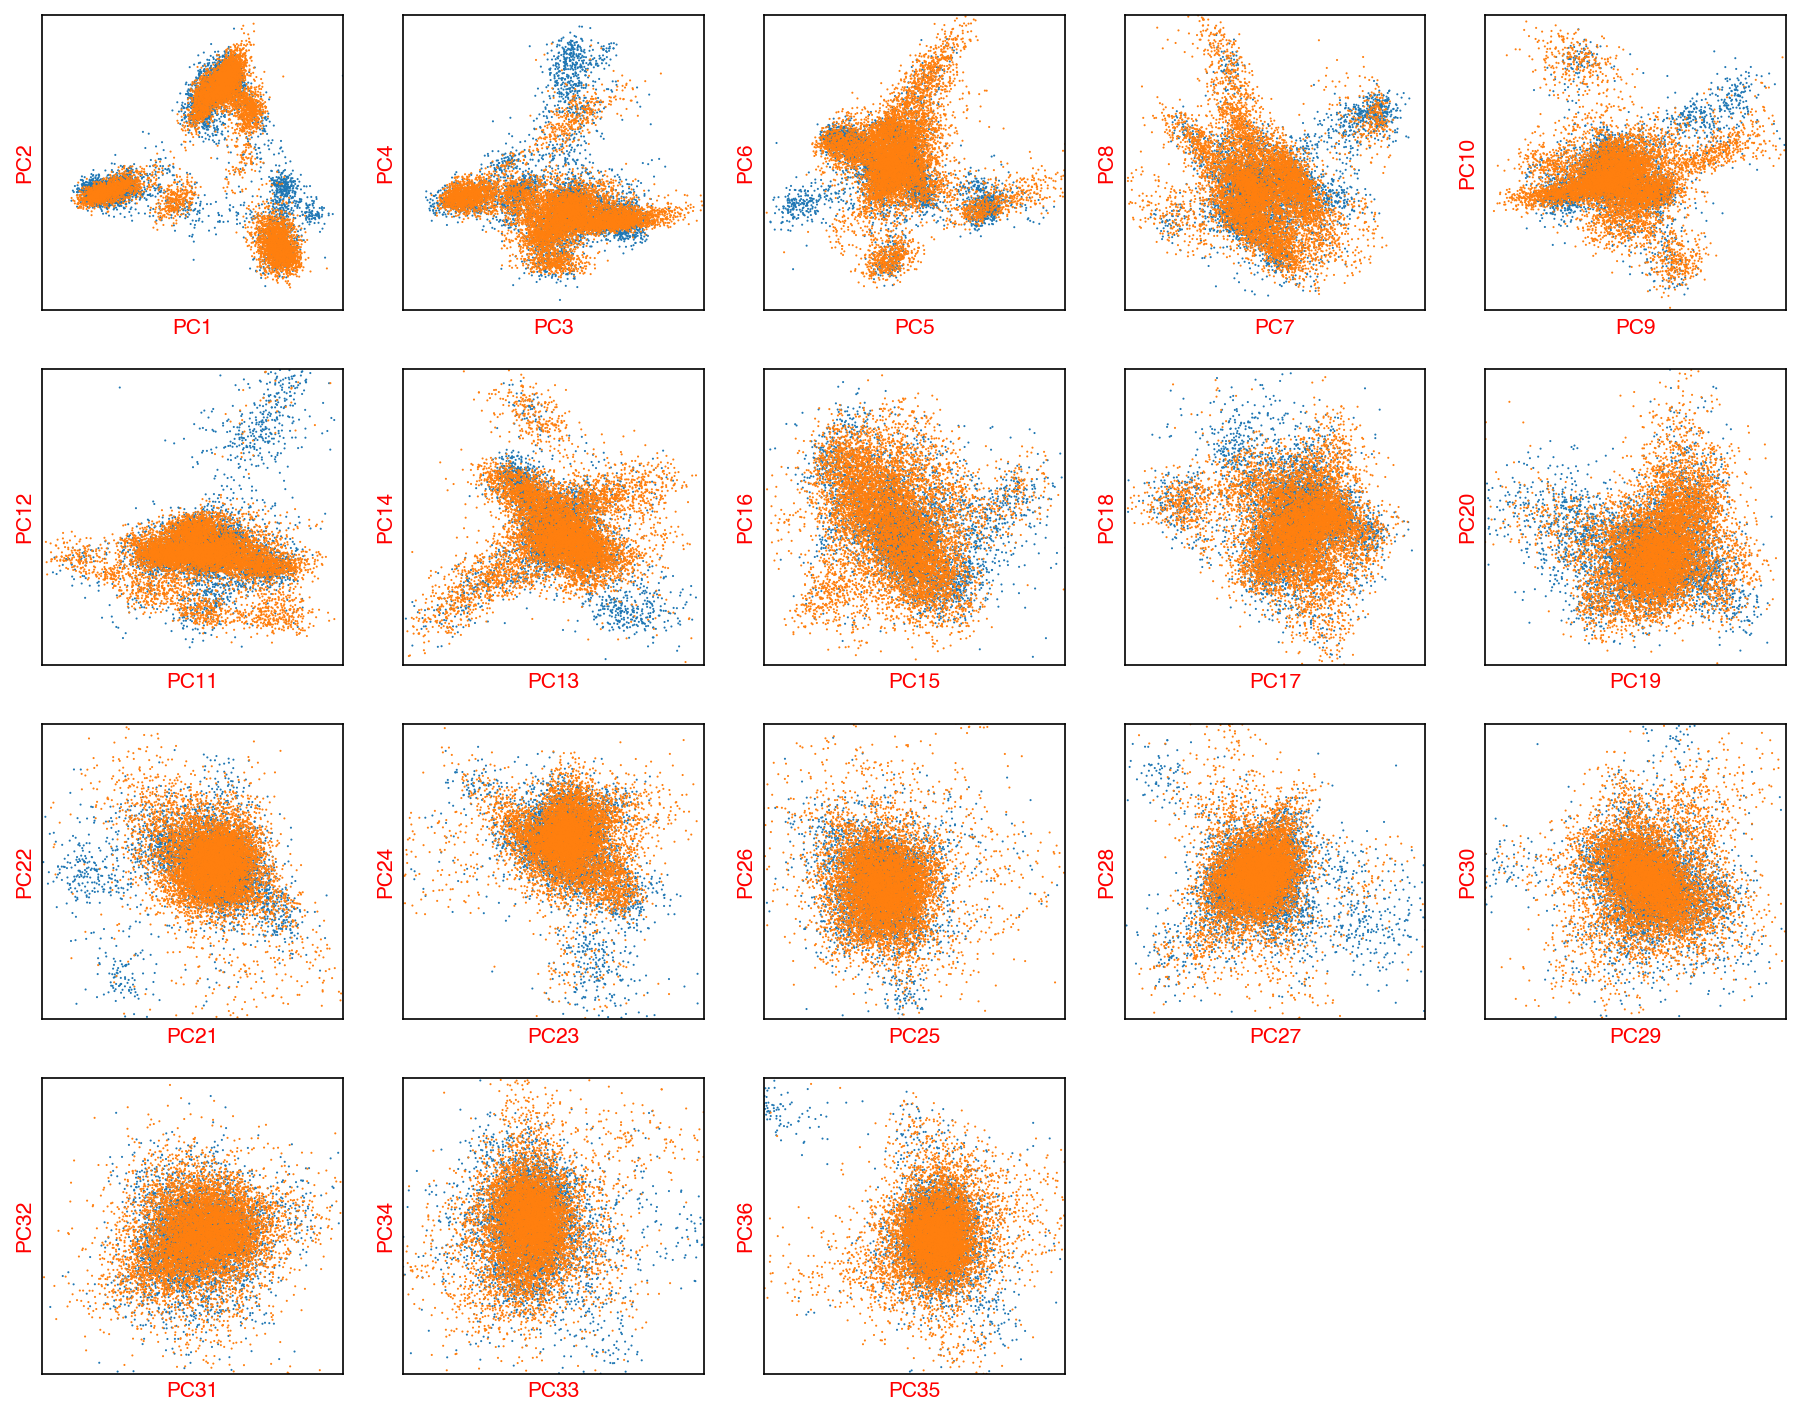

In [9]:
_ = plot_decomp_scatters(adata,
                         n_components=n_components,
                         hue='batch',
                         palette='tab10')

## Run co-clustering

In [10]:
sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.leiden(adata, resolution=resolution)

## Manifold Learning

In [11]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return

### tSNE

In [12]:
tsne(
    adata,
    obsm='X_pca',
    metric='euclidean',
    exaggeration=-1,  # auto determined
    perplexity=30,
    n_jobs=-1)
dump_embedding(adata, 'tsne')

### UMAP

In [13]:
sc.tl.umap(adata)
dump_embedding(adata, 'umap')

## Plot

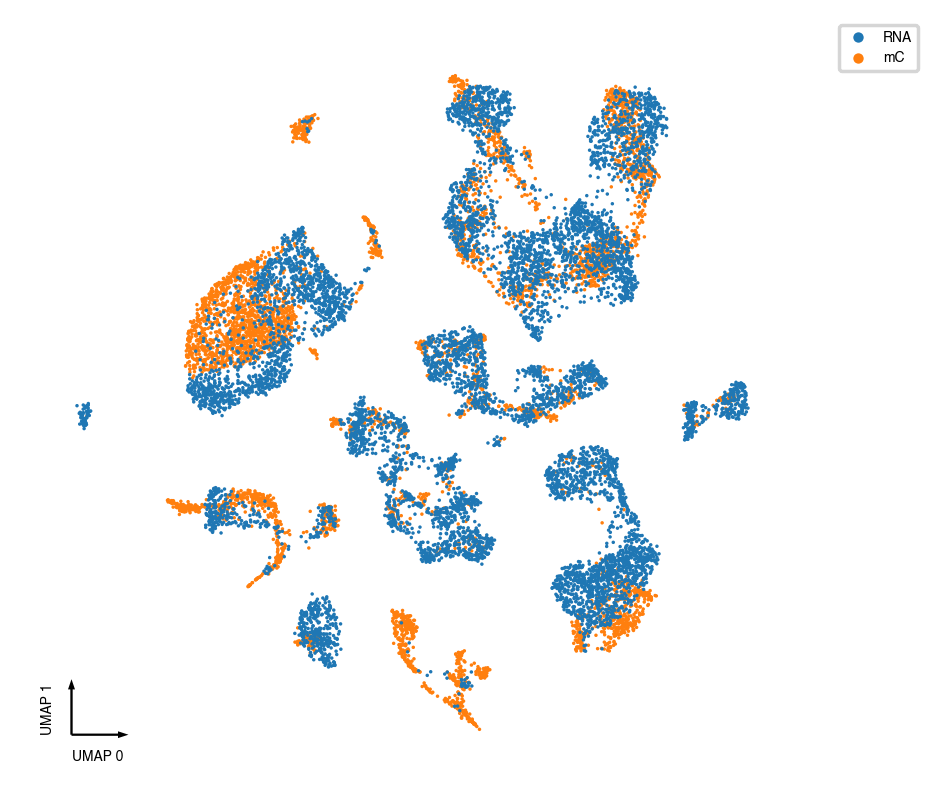

In [14]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(ax=ax,
                        data=adata.obs,
                        hue='batch',
                        show_legend=True,
                        max_points=None,
                        s=1)

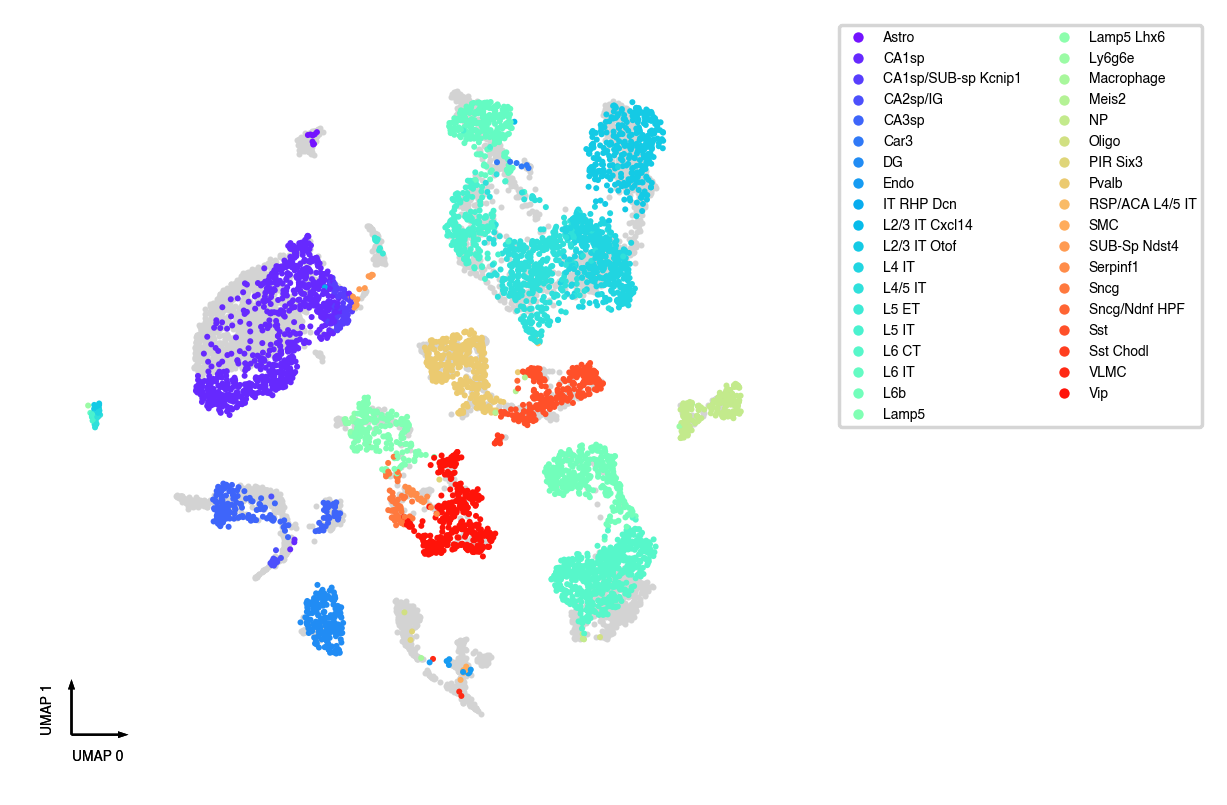

In [15]:
coord_base = 'umap'
mc_anno = 'CellTypeAnno'
rna_anno = 'subclass_label'

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(ax=ax,
                    coord_base=coord_base,
                    data=adata.obs[adata.obs['batch'] == 'mC'],
                    scatter_kws=dict(color='lightgray', zorder=0),
                    s=3)

categorical_scatter(ax=ax,
                    data=adata.obs[adata.obs['batch'] == 'RNA'],
                    hue=rna_anno,
                    coord_base=coord_base,
                    show_legend=True,
                    s=3)
pass

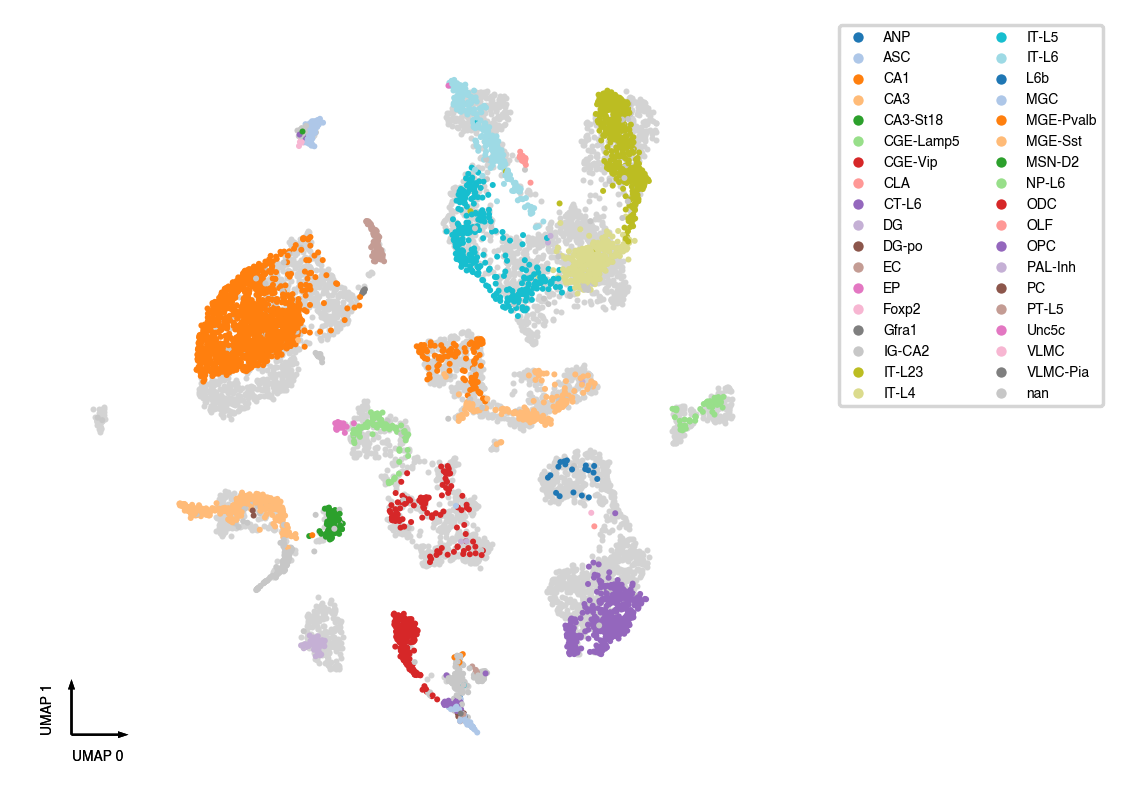

In [16]:
coord_base = 'umap'
mc_anno = 'CellTypeAnno'
rna_anno = 'subclass_label'

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
categorical_scatter(ax=ax,
                    coord_base=coord_base,
                    data=adata.obs[adata.obs['batch'] == 'RNA'],
                    scatter_kws=dict(color='lightgray', zorder=0),
                    s=3)

adata.obs[mc_anno] = adata.obs[mc_anno].astype(str)

categorical_scatter(ax=ax,
                    data=adata.obs[adata.obs['batch'] == 'mC'],
                    hue=mc_anno,
                    coord_base=coord_base,
                    palette='tab20',
                    show_legend=True,
                    s=3)
pass

## Confusion Matrix

In [17]:
mc_part = adata.obs.loc[adata.obs['batch'] == 'mC', [mc_anno, 'leiden']]
rna_part = adata.obs.loc[adata.obs['batch'] == 'RNA', [rna_anno, 'leiden']]

confusion_matrix = calculate_direct_confusion(mc_part, rna_part)

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/ALLCools/clustering/integration.py:40: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  union_index = left_row.index | right_row.index


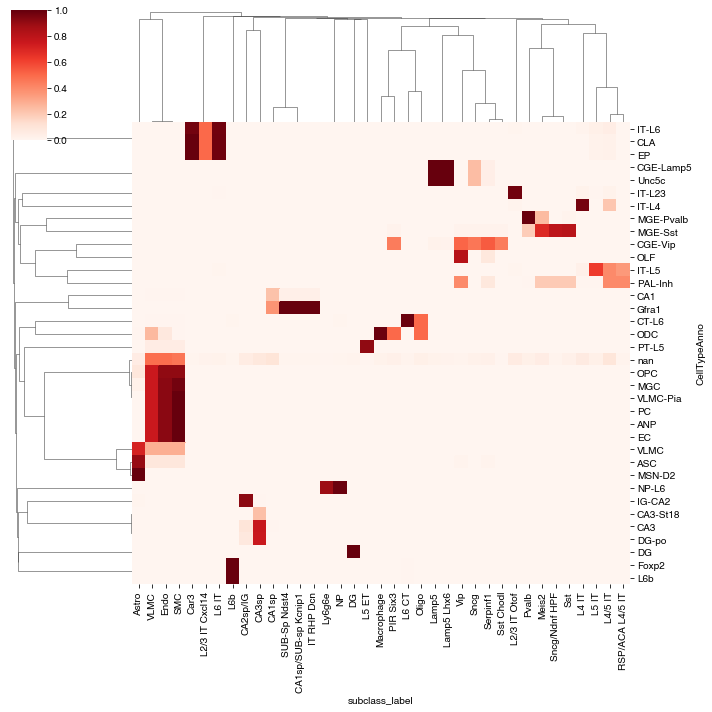

In [18]:
sns.clustermap(confusion_matrix, metric='correlation', cmap='Reds')